In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter
import src.kgbench as kg
import fire, sys
import math

from kgbench import load, tic, toc, d


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors


# #
#from torch_geometric.utils import to_networkx
# import networkx as nx

from src.rgcn_explainer_utils import *
from IPython.core.interactiveshell import InteractiveShell
from rgcn_model import RGCN



In [2]:
import os

# Get the current directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Check if the current directory is already the parent directory
if current_dir != '/Users/macoftraopia/Documents/GitHub/RGCN-Explainer':
    # Set the parent directory as the current directory
    os.chdir(parent_dir)
!pwd

/Users/macoftraopia/Documents/GitHub/RGCN-Explainer


Get the relations of the graph

In [3]:
import kgbench as kg
from src.rgcn_explainer_utils import *

data = kg.load('aifb', torch=True, final=False)
get_relations(data)
relations = [data.i2rel[i][0] for i in range(len(data.i2rel))]


loaded data aifb (0.236s).


In [11]:
data.withheld.shape

torch.Size([217, 2])

In [149]:
# ###functions
# def keep_columns_with_non_zero_values(df):
#     ''' Keep only columns with non-zero values'''

#     df = df.fillna(0)
#     # Get the column names with non-zero values
#     non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

#     # Create a new DataFrame with only the columns containing non-zero values
#     modified_df = df[non_zero_columns]

#     return modified_df

# def analysis(path,columns, type=True):
#     ''' Create df to compare predictions original vs explain'''
#     df = pd.read_csv(path+'/Relations_Important_full.csv', sep=',')
#     if type:
#         df.drop(columns=['type.1', 'type.2'], inplace=True)

#     # for i in columns:
#     #     df[i]/=2
#     df.set_index('node_idx', inplace=True)

#     df['label'] = df['label'].apply(lambda x: int(x[1])) 


#     df['tot'] = df[columns].sum(axis=1)
#     sum_per_group = df.groupby('label')[columns].sum()
#     tot_class = sum_per_group.mean(axis=1)
#     std_class = sum_per_group.std(axis=1)
    
    
#     #result = df[columns].div(df['number_neighbors'], axis=0) 
#     result = df[columns]
#     result['label']= df.label

#     result = keep_columns_with_non_zero_values(result)
#     if type:
#         result.drop(columns=['type'], inplace=True)

#     a = result.groupby('label') .aggregate(['mean'])

#     max_rows = a.idxmax()
#     #print('Average explanation lenght:', df['tot'].mean(), 'std:', df['tot'].std())

#     if type:
#         df['total_notype'] = df['tot']-df['type']
#         # print('Average explanation lenght without type:', df['total_notype'].mean(), 'std:', df['total_notype'].std())
#         columns_no_type = list(filter(lambda x: x != 'type', columns))
#         print('columns_no_type', columns_no_type)
#         sum_per_group_no_type = df.groupby('label')[columns_no_type].sum()
#         tot_class_no_type = sum_per_group_no_type.mean(axis=1)
#         std_class_no_type = sum_per_group_no_type.std(axis=1)
#     result_dict = {}
#     for column, value in max_rows.items():
#         if value in result_dict:
#             result_dict[value].append(column[0])
#         else:
#             result_dict[value] = [column[0]]
#     for i in set(df['label']):
#         if i not in result_dict.keys():
#             result_dict[i] = ''
#     d = {int(key): value for key, value in result_dict.items()}


#     d = dict(sorted(d.items()))
 
#     pd.set_option('display.max_colwidth', None)
#     d = pd.DataFrame(list(d.items()), columns=['Label', 'Relation'])
#     d = d.set_index('Label')
#     d['Relation'] = d['Relation'].apply(lambda x: ', '.join(x))

#     d['Original Mean degree'] = np.round(df.groupby('label')['number_neighbors'].mean(),3)
#     d['Exp Mean degree'] = np.round(tot_class,3)
#     d['Exp Std degree'] = np.round(std_class,3)

#     if type:
#         d['Exp Mean degree no type'] = np.round(tot_class_no_type,3)
#         d['Exp Std degree no type'] = np.round(std_class_no_type,3)
    
#     #d['% Removed Edges'] = np.round(((d['Original Mean degree']-d['Exp Mean degree'])*100)/d['Original Mean degree'],3)
#     #d['Sparsity'] = 1 - np.round(d['Exp Mean degree']/d['Original Mean degree'],3)

#     d['Fidelity Minus'] = np.round(df.groupby('label')['fidelity_minus'].mean(),3)
#     d['Fidelity Plus'] = np.round(df.groupby('label')['fidelity_plus'].mean(),3)
#     d['Sparsity'] = np.round(df.groupby('label')['sparsity'].mean(),3)

#     d['Fidelity Minus Threshold'] = np.round(df.groupby('label')['fidelity_minus_threshold'].mean(),3)
#     d['Fidelity Plus Threshold'] = np.round(df.groupby('label')['fidelity_plus_threshold'].mean(),3)
#     d['Sparsity Threshold'] = np.round(df.groupby('label')['sparsity_threshold'].mean(),3)

#     #df['fidelity_minus_random'] = float(1 - (df.prediction_full[int(df.label)] - df.prediction_random[int(df.label)]))
#     #d['Fidelity Minus Random'] = np.round(df.groupby('label')['fidelity_minus_random'].mean(),3)
    
#     return df, a, max_rows,d


# def accuracy_func(df, comparison='full', binary = True, inverse = False, overall = False,random=False):
#     ''' Compute per class accuracy
#     Args:
#         df: dataframe containing the results of the experiments
#         comparison: full, explain, explain binary, inverse
#         binary: True if binary explanation is considered, False otherwise
#         inverse: True if inverse explanation is considered, False otherwise
#         overall: True if overall accuracy is considered, False otherwise    
#     '''

#     mismatch, matc = {}, {}
#     match_count, mismatch_count = 0, 0

    
#     for index, row in df.iterrows():
#         if comparison == 'full':
#             c = np.argmax([float(num) for num in row['prediction_full'][1:-1].split()])
#         if comparison == 'explain':
#             if binary:
#                 c = np.argmax([float(num) for num in row['prediction_explain_binary'][1:-1].split()])
#             else:
#                 c = np.argmax([float(num) for num in row['prediction_explain'][1:-1].split()])
#             if inverse:
#                 c = np.argmax([float(num) for num in row['prediction_inverse_binary'][1:-1].split()])
#             if random:
#                 c = np.argmax([float(num) for num in row['prediction_random'][1:-1].split()])
        
#         original = int(row['label'])

#         match_count, mismatch_count = (match_count + 1, mismatch_count) if original == c else (match_count, mismatch_count + 1)
#         match_dict = matc if original == c else mismatch
#         match_dict.setdefault(original, []).append(index)

#     if overall:
#         overall_accuracy = match_count/(match_count+mismatch_count)
#         comparison = 'full' if comparison == 'full' else 'explain binary' if binary else 'inverse' if inverse else 'explain' 
#         print(f'Overall accuracy with {comparison}:', overall_accuracy)


#     labels = [int(i) for i in set(df['label'])]
#     accuracy = {i: len(matc[i]) / (len(matc[i]) + len(mismatch[i])) if i in mismatch.keys() and i in matc.keys() else (1 if i not in mismatch.keys() else 0) for i in labels}
#     accuracy = {key: value for key, value in accuracy.items()}
#     accuracy = dict(sorted(accuracy.items()))


#     accuracy = list(accuracy.values())

#     return mismatch, matc, accuracy

# def fidelity(df, modality = 'minus'):
#     ''' Compute fidelity as defined in the paper
#     Args:
#         df: dataframe containing the results of the experiments
#          modality: minus or plus depending on the type of fidelity to compute
#     '''

#     mismatch_f, matc_f, accuracy_f = accuracy_func(df, comparison='full')
#     if modality == 'minus':
#         mismatch_e, matc_e, accuracy_e = accuracy_func(df, comparison='explain')
#     if modality == 'plus':
#         mismatch_e, matc_e, accuracy_e = accuracy_func(df, comparison='explain', inverse=True)
#     fidelity = {i: accuracy_f[i] - accuracy_e[i] for i in range(len(accuracy_f))}
#     fidelity = {key: value for key, value in fidelity.items()}
#     fidelity = dict(sorted(fidelity.items()))
#     #print(f"Fidelity: {fidelity}")
#     return fidelity




# def result_table(path, relations, type=True, no_degrees=True):
#     ''' Create overleaf table to report results of experiments
#     Args:
#         path: path to folder containing results
#         relations: list of relations
#         type: True if type is not considered, False otherwise (to be reported in the table)
#         no_degrees: True if degrees are not reported in the table, False otherwise
#         '''
#     df, _, _,d = analysis(path,relations, type)
#     # _,_, accuracy = accuracy_func(df, comparison='explain',binary=False, overall=True)
#     # _,_, accuracy_binary = accuracy_func(df, comparison='explain',binary=True, overall=True)
#     fidelity_plus = fidelity(df, modality = 'plus')
#     fidelity_minus = fidelity(df, modality = 'minus')
#     # d['Fidelity plus'] = np.round(list(fidelity_plus.values()),3)
#     # d['Fidelity minus'] = 1 - np.round(list(fidelity_minus.values()),3)
#     fidelity_minus_random = fidelity(df, modality = 'minus')
#     d['Fidelity minus random '] = 1  - np.round(list(fidelity_minus_random.values()),3)

    
#     # d['Accuracy discrete'] = np.round(accuracy_binary,3)
#     # d['Accuracy soft'] = np.round(accuracy,3)
    

#     if no_degrees and not type:
#         d = d.drop(columns=['Exp Mean degree','Original Mean degree','Exp Std degree'])

#     if no_degrees and type:
#         d = d.drop(columns=['Exp Mean degree','Original Mean degree','Exp Std degree', 'Exp Mean degree no type', 'Exp Std degree no type'])



#     table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
#     latex_table = table.replace('\\midrule', '\\hline')
#     latex_table = latex_table.replace('\\toprule', '\\hline')
#     latex_table = latex_table.replace('\\bottomrule', '\\hline')
#     latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
#     latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    
#     return latex_table




In [151]:
#second tru hey 




###functions
def keep_columns_with_non_zero_values(df):
    ''' Keep only columns with non-zero values'''

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df

def analysis(path,columns, type=True):
    ''' Create df to compare predictions original vs explain'''
    df = pd.read_csv(path+'/Relations_Important_full_threshold.csv', sep=',')
    if type:
        df.drop(columns=['type.1', 'type.2'], inplace=True)

    df.set_index('node_idx', inplace=True)

    df['label'] = df['label'].apply(lambda x: int(x[1])) 
    #df['label'] = df['label'].apply(lambda x: int(x)) 


    df['tot'] = df[columns].sum(axis=1)
    sum_per_group = df.groupby('label')[columns].sum()
    tot_class = sum_per_group.mean(axis=1)
    std_class = sum_per_group.std(axis=1)
    
    
    #result = df[columns].div(df['number_neighbors'], axis=0) 
    result = df[columns]
    result['label']= df.label

    result = keep_columns_with_non_zero_values(result)
    if type:
        result.drop(columns=['type'], inplace=True)

    a = result.groupby('label').aggregate(['mean'])


    max_rows = a.idxmax()
    #print('Average explanation lenght:', df['tot'].mean(), 'std:', df['tot'].std())

    if type:
        df['total_notype'] = df['tot']-df['type']
        # print('Average explanation lenght without type:', df['total_notype'].mean(), 'std:', df['total_notype'].std())
        columns_no_type = list(filter(lambda x: x != 'type', columns))
        print('columns_no_type', columns_no_type)
        sum_per_group_no_type = df.groupby('label')[columns_no_type].sum()
        tot_class_no_type = sum_per_group_no_type.mean(axis=1)
        std_class_no_type = sum_per_group_no_type.std(axis=1)
    result_dict = {}
    for column, value in max_rows.items():
        if value in result_dict:
            result_dict[value].append(column[0])
        else:
            result_dict[value] = [column[0]]
    for i in set(df['label']):
        if i not in result_dict.keys():
            result_dict[i] = ''
    d = {int(key): value for key, value in result_dict.items()}


    d = dict(sorted(d.items()))
 
    pd.set_option('display.max_colwidth', None)
    d = pd.DataFrame(list(d.items()), columns=['Label', 'Relation'])
    d = d.set_index('Label')
    d['Relation'] = d['Relation'].apply(lambda x: ', '.join(x))

    d['Original Mean degree'] = np.round(df.groupby('label')['number_neighbors'].mean(),3)
    d['Exp Mean degree'] = np.round(tot_class,3)
    d['Exp Std degree'] = np.round(std_class,3)

    if type:
        d['Exp Mean degree no type'] = np.round(tot_class_no_type,3)
        d['Exp Std degree no type'] = np.round(std_class_no_type,3)
    
    #d['% Removed Edges'] = np.round(((d['Original Mean degree']-d['Exp Mean degree'])*100)/d['Original Mean degree'],3)
    #d['Sparsity'] = 1 - np.round(d['Exp Mean degree']/d['Original Mean degree'],3)

    # d['Fidelity Minus--'] = np.round(df.groupby('label')['fidelity_minus'].mean(),3)
    # d['Fidelity Plus--'] = np.round(df.groupby('label')['fidelity_plus'].mean(),3)
    # d['Sparsity'] = np.round(df.groupby('label')['sparsity'].mean(),3)

    # d['Fidelity Minus Threshold--'] = np.round(df.groupby('label')['fidelity_minus_threshold'].mean(),3)
    # d['Fidelity Plus Threshold--'] = np.round(df.groupby('label')['fidelity_plus_threshold'].mean(),3)
    # d['Sparsity Threshold'] = np.round(df.groupby('label')['sparsity_threshold'].mean(),3)

    #df['fidelity_minus_random'] = float(1 - (df.prediction_full[int(df.label)] - df.prediction_random[int(df.label)]))
    #d['Fidelity Minus Random'] = np.round(df.groupby('label')['fidelity_minus_random'].mean(),3)
    
    return df, a, max_rows,d




def fidelity(df, modality ,comparison_minus=None, comparison_inverse=None):
    ''' Compute fidelity as defined in the paper
    Args:
        df: dataframe containing the results of the experiments
         modality: minus or plus depending on the type of fidelity to compute
    '''

    mismatch_f, matc_f, accuracy_f = accuracy_func(df, comparison ='prediction_full')
    if modality == 'minus':
        mismatch_e, matc_e, accuracy_e = accuracy_func(df, comparison=comparison_minus)
        fidelity = {i: accuracy_f[i] - accuracy_e[i] for i in range(len(accuracy_f))}
        fidelity = {key: value for key, value in fidelity.items()}
        fidelity = dict(sorted(fidelity.items()))
    if modality == 'plus':
        mismatch_e, matc_e, accuracy_e = accuracy_func(df, comparison=comparison_inverse)
        fidelity = {i: accuracy_f[i] - accuracy_e[i] for i in range(len(accuracy_f))}
        fidelity = {key: value for key, value in fidelity.items()}
        fidelity = dict(sorted(fidelity.items()))
    #print(f"Fidelity: {fidelity}")
    return fidelity




def result_table(path, relations, type=True, no_degrees=True, pred_prob_fid = False):
    ''' Create overleaf table to report results of experiments
    Args:
        path: path to folder containing results
        relations: list of relations
        type: True if type is not considered, False otherwise (to be reported in the table)
        no_degrees: True if degrees are not reported in the table, False otherwise
        '''
    df, _, _,d = analysis(path,relations, type)
    # _,_, accuracy = accuracy_func(df, comparison='explain',binary=False, overall=True)
    # _,_, accuracy_binary = accuracy_func(df, comparison='explain',binary=True, overall=True)
    if pred_prob_fid==False:
        fidelity_minus = fidelity(df, modality = 'minus',comparison_minus ='prediction_explain_binary')
        fidelity_plus = fidelity(df, modality = 'plus', comparison_inverse = 'prediction_inverse_binary')
        # d['Sparsity'] = np.round(df.groupby('label')['sparsity'].mean(),3)
        # d['Fidelity-'] = 1 - np.round(list(fidelity_minus.values()),3)
        # d['Fidelity+'] = np.round(list(fidelity_plus.values()),3)
        

        fidelity_plus_threshold = fidelity(df, modality = 'plus', comparison_inverse= 'res_threshold_lekker_inverse')
        fidelity_minus_threshold = fidelity(df, modality = 'minus', comparison_minus = 'prediction_threshold_lekker')
        d['Sparsity '] = np.round(df.groupby('label')['sparsity_threshold'].mean(),3)
        d['Fidelity- '] = 1 - np.round(list(fidelity_minus_threshold.values()),3)
        d['Fidelity+ '] = np.round(list(fidelity_plus_threshold.values()),3)
        
        #fidelity_minus_thres = fidelity(df, modality = 'minus', comparison_minus = 'prediction_threshold')
        #d['Fidelity minus Thresh'] = 1 - np.round(list(fidelity_minus_thres.values()),3)

        fidelity_plus_random = fidelity(df, modality = 'plus', comparison_inverse= 'res_random_inverse')
        fidelity_minus_random = fidelity(df, modality = 'minus', comparison_minus = 'prediction_random')
        d['Fidelity- Random'] = 1 - np.round(list(fidelity_minus_random.values()),3)
        d['Fidelity+ Random'] = np.round(list(fidelity_plus_random.values()),3)
    else:
        d['Sparsity'] = np.round(df.groupby('label')['sparsity'].mean(),3)
        d['Fidelity-'] = np.round(df.groupby('label')['fidelity_minus'].mean(),3)
        d['Fidelity+'] = np.round(df.groupby('label')['fidelity_plus'].mean(),3)
        

        d['Sparsity Threshold'] = np.round(df.groupby('label')['sparsity_threshold'].mean(),3)
        d['Fidelity- Threshold'] = np.round(df.groupby('label')['fidelity_minus_threshold'].mean(),3)
        d['Fidelity+ Threshold'] = np.round(df.groupby('label')['fidelity_plus_threshold'].mean(),3)
        
        d['Fidelity- Random'] = np.round(df.groupby('label')['fidelity_minus_random'].mean(),3)
        d['Fidelity+ Random'] = np.round(df.groupby('label')['fidelity_plus_random'].mean(),3)
        


    # d['Accuracy discrete'] = np.round(accuracy_binary,3)
    # d['Accuracy soft'] = np.round(accuracy,3)
    

    if no_degrees and not type:
        d = d.drop(columns=['Exp Mean degree','Original Mean degree','Exp Std degree'])

    if no_degrees and type:
        d = d.drop(columns=['Exp Mean degree','Original Mean degree','Exp Std degree', 'Exp Mean degree no type', 'Exp Std degree no type'])



    table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')
    latex_table = table.replace('\\midrule', '\\hline')
    latex_table = latex_table.replace('\\toprule', '\\hline')
    latex_table = latex_table.replace('\\bottomrule', '\\hline')
    latex_table = latex_table.replace('\\begin{tabular}', '\\begin{adjustbox}{scale=0.5}\\begin{tabular}')  # Add scaling parameter
    latex_table = latex_table.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')  # Close the adjustbox environment
    
    return latex_table


def accuracy_func(df, comparison='prediction_full'):
    ''' Compute per class accuracy
    Args:
        df: dataframe containing the results of the experiments
        comparison: full, explain, explain binary, inverse
        binary: True if binary explanation is considered, False otherwise
        inverse: True if inverse explanation is considered, False otherwise
        overall: True if overall accuracy is considered, False otherwise    
    '''
    mismatch, matc = {}, {}
    match_count, mismatch_count = 0, 0

    
    for index, row in df.iterrows():

        c = np.argmax([float(num) for num in row[comparison][1:-1].split()])

        #original = int(row['label'])
        original = np.argmax(row['prediction_full'][1:-1].split())

        match_count, mismatch_count = (match_count + 1, mismatch_count) if original == c else (match_count, mismatch_count + 1)
        match_dict = matc if original == c else mismatch
        match_dict.setdefault(original, []).append(index)


    #labels = [int(i) for i in set(df['label'])]
    labels = [np.argmax([float(num) for num in row['prediction_full'][1:-1].split()]) for index, row in df.iterrows()]

    accuracy = {i: len(matc[i]) / (len(matc[i]) + len(mismatch[i])) if i in mismatch.keys() and i in matc.keys() else (1 if i not in mismatch.keys() else 0) for i in labels}
    #accuracy = {key: value for key, value in accuracy.items()}
    accuracy = dict(sorted(accuracy.items()))


    accuracy = list(accuracy.values())

    return mismatch, matc, accuracy

In [123]:
def analysis(path,columns, type=True):
    ''' Create df to compare predictions original vs explain'''
    df = pd.read_csv(path+'/Relations_Important_full_threshold.csv', sep=',')
    if type:
        df.drop(columns=['type.1', 'type.2'], inplace=True)

    df.set_index('node_idx', inplace=True)

    df['label'] = df['label'].apply(lambda x: int(x[1])) 
    #df['label'] = df['label'].apply(lambda x: int(x)) 


    df['tot'] = df[columns].sum(axis=1)
    sum_per_group = df.groupby('label')[columns].sum()
    tot_class = sum_per_group.mean(axis=1)
    std_class = sum_per_group.std(axis=1)
    
    
    #result = df[columns].div(df['number_neighbors'], axis=0) 
    result = df[columns]
    result['label']= df.label

    result = keep_columns_with_non_zero_values(result)
    if type:
        result.drop(columns=['type'], inplace=True)

    a = result.groupby('label').aggregate(['mean'])


    max_rows = a.idxmax()
    #print('Average explanation lenght:', df['tot'].mean(), 'std:', df['tot'].std())

    if type:
        df['total_notype'] = df['tot']-df['type']
        # print('Average explanation lenght without type:', df['total_notype'].mean(), 'std:', df['total_notype'].std())
        columns_no_type = list(filter(lambda x: x != 'type', columns))
        print('columns_no_type', columns_no_type)
        sum_per_group_no_type = df.groupby('label')[columns_no_type].sum()
        tot_class_no_type = sum_per_group_no_type.mean(axis=1)
        std_class_no_type = sum_per_group_no_type.std(axis=1)
    result_dict = {}
    for column, value in max_rows.items():
        if value in result_dict:
            result_dict[value].append(column[0])
        else:
            result_dict[value] = [column[0]]
    for i in set(df['label']):
        if i not in result_dict.keys():
            result_dict[i] = ''
    d = {int(key): value for key, value in result_dict.items()}


    d = dict(sorted(d.items()))
 
    pd.set_option('display.max_colwidth', None)
    d = pd.DataFrame(list(d.items()), columns=['Label', 'Relation'])
    d = d.set_index('Label')
    d['Relation'] = d['Relation'].apply(lambda x: ', '.join(x))

    d['Original Mean degree'] = np.round(df.groupby('label')['number_neighbors'].mean(),3)
    d['Exp Mean degree'] = np.round(tot_class,3)
    d['Exp Std degree'] = np.round(std_class,3)

    if type:
        d['Exp Mean degree no type'] = np.round(tot_class_no_type,3)
        d['Exp Std degree no type'] = np.round(std_class_no_type,3)

    
    return df, a, max_rows,d

def select_columns_with_values_above_threshold(df, threshold):
    # Select columns where there is at least one entry higher than 1
    selected_columns = df.columns[(df > threshold).any()]

    # Create a new DataFrame with the selected columns
    modified_df = df[selected_columns]

    return modified_df


In [150]:
#path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/Relation_Importance'

path = 'chk/aifb_chk/exp/init_relative_frequency_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance'
#path = 'chk/aifb_chk/exp/init_domain_frequency_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance'

def relations_important_as_baseline(path):
    ''' Compute the most important relations per class'''
    df = pd.read_csv(f'{path}/Relations_Important_full_threshold.csv')
    df.set_index('node_idx', inplace=True)
    df_ = df[relations]
    #df_['tot'] = df_[relations].sum(axis=1)
    df_ = df_.fillna(0)
    df_ = df_.applymap(lambda x: 1 if x != 0 else x) 
    df_['label'] = df['label'].apply(lambda x: int(x[1]))
    gb = df_.groupby('label')  
    a = gb.aggregate('mean') #a = gb.sum()
    a = a.fillna(0)
    a.drop('type', axis=1, inplace=True)
    a = keep_columns_with_non_zero_values(a)
    a_high = select_columns_with_values_above_threshold(a,0.5)
    a_high
    def select_columns(row):
        return ', '.join(row[row > 0.5].index)
    a_high['selected_columns'] = a_high.apply(select_columns, axis=1)
    return a_high['selected_columns']
print(relations_important_as_baseline(path))



 
def important_relation_percentage(path):
    ''' Compute the percentage of important relations per class'''
    df = pd.read_csv(f'{path}/Relations_Important_full_threshold.csv')
    df.set_index('node_idx', inplace=True)
    df['tot'] = df[relations].sum(axis=1)
    df_ = df[relations].div(df['tot'], axis=0)
    df_['label'] = df['label'].apply(lambda x: int(x[1]))
    df_ = df_.fillna(0)
    df_ = keep_columns_with_non_zero_values(df_)

    gb = df_.groupby('label')   
    a = gb.aggregate('mean') #a = gb.sum()
    a = keep_columns_with_non_zero_values(a)
    a.drop('type', axis=1, inplace=True)
    a
    def select_columns(row):
        return ', '.join(row[row > np.mean(row)].index)

    # Apply the function to each row and store the result in a new column
    a['selected_columns'] = a.apply(select_columns, axis=1)
    return a['selected_columns']

important_relation_percentage(path)





#The number of important relations per node are divided by the explanation length, such that each value correspond to the importance of a relation in the explanation in terms of percentage.
#The average importance of each relation is computed for each class and for each class the relations defined as important are the ones with an average percentage higher than 10 percent.


# the relation with the highest average importance is selected as the most important relation for that class.


label
0                                                                     fax, phone
1     fax, isWorkedOnBy, member, name, phone, photo, publication, worksAtProject
2    author, fax, isWorkedOnBy, member, name, phone, publication, worksAtProject
3     fax, isWorkedOnBy, member, name, phone, photo, publication, worksAtProject
Name: selected_columns, dtype: object


/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2769183211.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a_high['selected_columns'] = a_high.apply(select_columns, axis=1)


label
0                  author, fax, phone
1    author, fax, member, publication
2    author, fax, member, publication
3    author, fax, member, publication
Name: selected_columns, dtype: object

In [159]:

path = 'chk/aifb_chk/exp/init_range_frequency_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance'
#path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/Relation_Importance'
#path = 'chk/mutag_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance'
#df = pd.read_csv('chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance/Relations_Important_full.csv')
#df.columns
d = result_table(path,relations, type=False, no_degrees=True)
print(d)

\begin{table}
\centering
\caption{init-range-frequency-hops-2-lr-0.5-adaptive-False-size-0.005-sizestd-adaptive-ent-10-type-1-killtype-True-break-no}
\label{init-range-frequency-hops-2-lr-0.5-adaptive-False-size-0.005-sizestd-adaptive-ent-10-type-1-killtype-True-break-no}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &                                                           Relation &  Sparsity  &  Fidelity-  &  Fidelity+  &  Fidelity- Random &  Fidelity+ Random \\
Label &                                                                    &            &             &             &                   &                   \\
\hline
0     &     homepage, type, type, type, type, type, type, type, type, type &      0.884 &       1.000 &      -0.067 &             0.867 &             0.000 \\
1     &                                                        name, photo &      0.888 &       1.000 &       0.571 &             0.857 &             0.000

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2873936871.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['label']= df.label
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2873936871.py:188: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [33]:
path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_5e-05_sizestd_adaptive_ent_1_type_1_killtype_True_break_no/Relation_Importance'
#path = 'chk/mutag_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance'
#df = pd.read_csv('chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance/Relations_Important_full.csv')
#df.columns
d = result_table(path,relations, type=False, no_degrees=True)
print(d)

\begin{table}
\centering
\caption{init-normal-hops-2-lr-0.5-adaptive-False-size-5e-05-sizestd-adaptive-ent-1-type-1-killtype-True-break-no}
\label{init-normal-hops-2-lr-0.5-adaptive-False-size-5e-05-sizestd-adaptive-ent-1-type-1-killtype-True-break-no}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &                                                        Relation &  Sparsity  &  Fidelity-  &  Fidelity+  &  Fidelity- Random &  Fidelity+ Random \\
Label &                                                                 &            &             &             &                   &                   \\
\hline
0     &  homepage, type, type, type, type, type, type, type, type, type &      0.919 &         1.0 &       0.000 &             1.067 &             0.000 \\
1     &                                     name, photo, worksAtProject &      0.960 &         1.0 &       0.143 &             0.571 &             0.000 \\
2     &                     

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2873936871.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['label']= df.label
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2873936871.py:188: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [29]:
path = 'chk/aifb_chk/exp/init_normal_hops_2_lr_0.5_adaptive_False_size_0.005_sizestd_adaptive_ent_10_type_1_killtype_True_break_no/Relation_Importance'
df = pd.read_csv(f'{path}/Relations_Important_full_threshold.csv')
d = result_table(path,relations, type=False, no_degrees=True, pred_prob_fid=True)
print(d)

\begin{table}
\centering
\caption{init-normal-hops-2-lr-0.5-adaptive-False-size-0.005-sizestd-adaptive-ent-10-type-1-killtype-True-break-no}
\label{init-normal-hops-2-lr-0.5-adaptive-False-size-0.005-sizestd-adaptive-ent-10-type-1-killtype-True-break-no}
\begin{adjustbox}{scale=0.5}\begin{tabular}{|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|}
\hline
{} &                                                                      Relation &  Sparsity &  Fidelity- &  Fidelity+ &  Sparsity Threshold &  Fidelity- Threshold &  Fidelity+ Threshold &  Fidelity- Random &  Fidelity+ Random \\
Label &                                                                               &           &            &            &                     &                      &                      &                   &                   \\
\hline
0     &                                                                      homepage &     0.926 &      0.816 &      0.054 &               0.920 &                0.804 &          

/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2873936871.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['label']= df.label
/var/folders/ww/33zq_rh50tx94n81lb4thx0w0000gn/T/ipykernel_62962/2873936871.py:188: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  table = d.to_latex(index=True, caption = path.split('/')[-2].replace('_','-'), label = path.split('/')[-2].replace('_','-'),column_format='|c|m{3cm}|c|c|c|c|c|c|c|c|c|c|c|c|c|c|')


In [132]:
# Read in the data
path = 'Relation_Importance_aifb/2_hops_size_0.005_lr_0.1_epochs_30_threshold_0.5_init_normal'
df = pd.read_csv(path+'/Relations_Important_aifb_full.csv', sep=',')
df.set_index('node_idx', inplace=True)

df['label'] = df['label'].apply(lambda x: x[1]) 
columns = relations


gb = df.groupby('label')   

df['tot'] = df[columns].sum(axis=1)
result = df[columns].div(df['tot'], axis=0) 
result = df[columns].div(df['number_neighbors'], axis=0)
result['label']= df.label
result.head(5)

result = keep_columns_with_non_zero_values(result)
#result.drop(columns=['type'], inplace=True)
gb = result.groupby('label') 

a = gb.aggregate(['mean', 'std'])

max_rows = a.idxmax()

max_rows
a


author              editor                 fax            homepage  \
           mean       std      mean       std      mean       std      mean   
label                                                                         
0      0.016272  0.025921  0.000251  0.000938  0.149678  0.088999  0.014212   
1      0.028380  0.021067  0.000000  0.000000  0.091000  0.098383  0.000900   
2      0.198416  0.238441  0.006316  0.017797  0.064998  0.090023  0.000912   
3      0.026864  0.024777  0.000000  0.000000  0.169238  0.074628  0.000000   

                isWorkedOnBy            ...      name               phone  \
            std         mean       std  ...      mean       std      mean   
label                                   ...                                 
0      0.019511     0.013427  0.024975  ...  0.001726  0.000882  0.075706   
1      0.001039     0.024224  0.024328  ...  0.001371  0.000915  0.002275   
2      0.001704     0.065786  0.062239  ...  0.001354  0.000690  0.005036   
3      0.000000     0.022351  0.023330  ...  0.001218  0.000944  0.055706   

                    photo           publication           worksAtProject  \
            std      mean       std        mean       std           mean   
label                                                                      
0      0.056242  0.000125  0.000467    0.014725  0.024364       0.001765   
1      0.000889  0.000904  0.001044    0.025232  0.019116       0.008104   
2      0.005185  0.000879  0.000855    0.198180  0.256003       0.022623   
3      0.059527  0.001526  0.000748    0.024172  0.022694       0.007874   

                 
            std  
label            
0      0.004014  
1      0.006664  
2      0.025626  
3      0.006896  

[4 rows x 22 columns]

In [141]:
import numpy as np

def full_vs_explain(df):
    mismatch = []
    match = []
    for index, row in df.iterrows():
        obj = row['prediction_explain_binary']
        #obj = row['prediction_explain']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        explain = np.argmax(my_list)
        
        obj = row['prediction_full']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        full = np.argmax(my_list)
        original = row['label']

        if full == explain:
            #print(f"Row {index}: Full and explain match.")
            match.append(index)
        elif original != explain:
            #print(f"Row {index}: Full and explain differ.")
            mismatch.append(index)
        elif full == explain != row['label']:
            print(f"Row {index}: Full and explain match but not label.")
        elif full != explain == row['label']:
            print(f"Row {index}: Full and explain differ but explain match label.")
    print(f"Total mismatch: {len(mismatch)}")
    print(f"Mismatch: {mismatch}")
    print(f"Accuracy: {len(match)/(len(match)+len(mismatch))}")
    return mismatch, match



mismatch, match = full_vs_explain(df)


Total mismatch: 3
Mismatch: [5783, 5839, 5844]
Accuracy: 0.9142857142857143


In [62]:
selected_rows = df.loc[mismatch]['number_neighbors']
print('num neighbors for wrong ones',selected_rows)

labels = df.loc[mismatch]['label']
print('labels for wrong ones',labels)

types = df.loc[mismatch]['type']
print('types for wrong ones',types)


df.loc[mismatch]

num neighbors for wrong ones node_idx
5783    1078
5905    1056
5785    1109
5831    1115
5839    1087
5844    1067
5752    1119
5795    1080
5854    1136
Name: number_neighbors, dtype: int64
labels for wrong ones node_idx
5783    [0]
5905    [1]
5785    [1]
5831    [2]
5839    [2]
5844    [2]
5752    [3]
5795    [3]
5854    [3]
Name: label, dtype: object
types for wrong ones node_idx
5783     672
5905     718
5785     748
5831     756
5839     968
5844    2090
5752     808
5795     716
5854    1080
Name: type, dtype: int64


In [16]:
df_rel = df.iloc[:,1:].div(df.tot, axis=0)
df_rel['label'] = df['label']

df_rel.dropna(axis=1, how='all')


,author,carriedOutBy,carriesOut,dealtWithIn,editor,fax,hasProject,homepage,isAbout,isWorkedOnBy,...,photo,projectInfo,publication,publishes,type,worksAtProject,type.1,type.2,tot,label
node_idx,,,,,,,,,,,,,,,,,,,,,
5678,0.103448,0.017241,0.017241,0.086207,0.017241,0.017241,0.051724,0.017241,0.086207,0.068966,...,0.017241,0.051724,0.155172,0.172414,0.017241,0.017241,0.017241,0.017241,1.0,0
5724,0.125000,NaN,NaN,NaN,NaN,0.125000,NaN,0.125000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.125000,NaN,0.125000,0.125000,1.0,0
5699,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,0.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5688,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5702,0.250000,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5714,NaN,NaN,NaN,NaN,NaN,0.500000,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5708,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,0.250000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0
5843,0.181818,NaN,NaN,0.045455,NaN,0.045455,0.090909,NaN,0.272727,0.136364,...,NaN,0.045455,0.090909,NaN,NaN,NaN,NaN,NaN,1.0,0
5873,NaN,NaN,NaN,NaN,NaN,0.250000,NaN,NaN,NaN,NaN,...,0.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0


In [31]:
from collections import Counter
Counter(df_rel['label'])

Counter({0: 14, 1: 4, 2: 11, 3: 6})

In [37]:
#select one row of df according to node_idx index value
df_rel.loc[5757].sort_values()



name              0.0625
type              0.0625
type.1            0.0625
type.2            0.0625
publication       0.2500
author            0.3750
tot               1.0000
label             2.0000
abstract             NaN
address              NaN
booktitle            NaN
carriedOutBy         NaN
carriesOut           NaN
chapter              NaN
dealtWithIn          NaN
edition              NaN
editor               NaN
fax                  NaN
financedBy           NaN
finances             NaN
hasProject           NaN
head                 NaN
homepage             NaN
howpublished         NaN
isAbout              NaN
isWorkedOnBy         NaN
isbn                 NaN
journal              NaN
member               NaN
month                NaN
note                 NaN
number               NaN
pages                NaN
phone                NaN
photo                NaN
projectInfo          NaN
publishes            NaN
series               NaN
title                NaN
volume               NaN


In [39]:
a = torch.load('/Users/macoftraopia/Documents/GitHub/RGCN-Explainer/chk/mdgenre_chk/prediction_mdgenre_prune_False')
a.shape

torch.Size([3000, 12])

In [28]:
for i in np.unique(df_rel['label']):
    exec(f'group_{i} = gb.get_group(i)')
    exec(f'group_rel_{i} = group_{i}.iloc[:,1:].div(group_{i}.tot, axis=0)')
    exec(f'group_rel_{i} = group_rel_{i}.drop(columns=["tot"])')
    exec(f'group_max_{i} = group_rel_{i}.idxmax(axis=1)')

#group_rel_0
print('group_max_0: \n', group_max_0.value_counts(),
      '\n group_max_1 \n', group_max_1.value_counts(),#,
         '\n group_max_2 \n', group_max_2.value_counts(),
         '\n group_max_3 \n', group_max_3.value_counts())

group_max_0: 
 fax            7
author         4
publishes      1
isAbout        1
dealtWithIn    1
dtype: int64 
 group_max_1 
 isAbout    2
author     2
dtype: int64 
 group_max_2 
 author         5
isAbout        3
hasProject     1
projectInfo    1
publication    1
dtype: int64 
 group_max_3 
 isAbout        3
author         1
publication    1
fax            1
dtype: int64


In [29]:
print('group_max_0: \n', group_max_0.value_counts, )

group_max_0: 
 <bound method IndexOpsMixin.value_counts of node_idx
5678      publishes
5724         author
5699            fax
5688            fax
5702         author
5714            fax
5708            fax
5843        isAbout
5873            fax
5697            fax
5783         author
5701            fax
5845    dealtWithIn
5778         author
dtype: object>


In [17]:
from dfply import *
# summary statistics for dependent variable AUTHOR
df_rel >> group_by(X.label) >> summarize(n=X['author'].count(), mean=X['author'].mean(), std=X['author'].std())
# output

,label,n,mean,std
0,0,7,0.195746,0.095461
1,1,4,0.151612,0.025134
2,2,11,0.176738,0.125399
3,3,4,0.132441,0.019422


In [18]:
from dfply import *
# summary statistics for dependent variable AUTHOR
df_rel >> group_by(X.label) >> summarize(n=X['dealtWithIn'].count(), mean=X['dealtWithIn'].mean(), std=X['dealtWithIn'].std())
# output

,label,n,mean,std
0,0,3,0.092372,0.050284
1,1,1,0.032258,NaN
2,2,5,0.026256,0.017000
3,3,1,0.055556,NaN


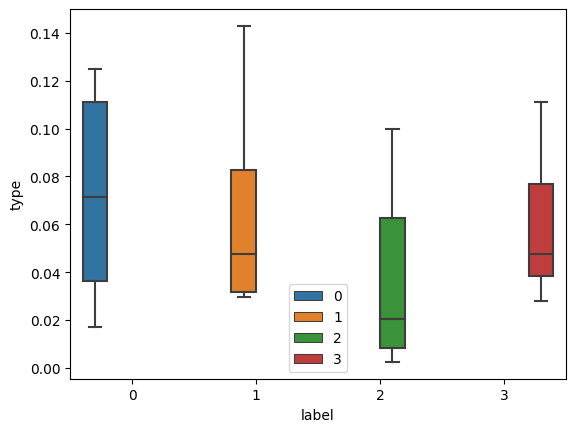

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
#fig, axs = plt.subplots(ncols=2)
sns.boxplot(data=df_rel, x="label", y="type",  hue=df.label.tolist())
#sns.boxplot(data=df_rel, x="plant_var", y="canopy_vol", hue=df.plant_var..tolist(), ax=axs[1])
plt.show()

In [20]:
from statsmodels.multivariate.manova import MANOVA
fit = MANOVA.from_formula('author + fax ~ label', data=df)
print(fit.mv_test())

                                Multivariate linear model
                                                                                         
-----------------------------------------------------------------------------------------
       Intercept                Value         Num DF Den DF        F Value         Pr > F
-----------------------------------------------------------------------------------------
          Wilks' lambda               -0.0000 2.0000 9.0000 -2895171189023894.5000 1.0000
         Pillai's trace                1.0000 2.0000 9.0000 -2895171189023895.0000 1.0000
 Hotelling-Lawley trace -643371375338643.2500 2.0000 9.0000 -2895171189023894.5000 1.0000
    Roy's greatest root -643371375338643.2500 2.0000 9.0000 -2895171189023894.5000 1.0000
-----------------------------------------------------------------------------------------
                                                                                         
------------------------------------------

In [21]:
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(group_rel_0['author'], group_rel_1['author'])
print(fvalue, pvalue)

nan nan


In [ ]:
###functions
def keep_columns_with_non_zero_values(df):

    df = df.fillna(0)
    # Get the column names with non-zero values
    non_zero_columns = df.columns[df.astype(bool).any(axis=0)]

    # Create a new DataFrame with only the columns containing non-zero values
    modified_df = df[non_zero_columns]

    return modified_df

def analysis(path,columns):
    df = pd.read_csv(path+'/Relations_Important_aifb_full.csv', sep=',')
    df.set_index('node_idx', inplace=True)

    df['label'] = df['label'].apply(lambda x: x[1]) 


    df['tot'] = df[columns].sum(axis=1)/2  
    result = df[columns].div(2, axis=0)
    
    
    result['tot'] = result[columns].sum(axis=1)

    #print('Average explanation lenght:', result['tot'].mean(), 'std:', result['tot'].std())
    #result = df[columns].div(df['number_neighbors'], axis=0)

    result = keep_columns_with_non_zero_values(result)
    result.drop(columns=['type'], inplace=True)
    result['total_notype'] = result.sum(axis=1) - result['tot']
    
    #print('Average explanation lenght without type:', result['total_notype'].mean(), 'std:', result['total_notype'].std())

    r = df[columns].div(df['number_neighbors'], axis=0) 
    r['label']= df.label
    gb = r.groupby('label') 

    # a = gb.aggregate(['mean', 'std'])
    a = gb.aggregate(['mean'])

    max_rows = a.idxmax()

    

    return df, a, max_rows

import numpy as np

def full_vs_explain(df):
    
    mismatch = []
    match = []
    for index, row in df.iterrows():
        obj = row['prediction_explain_binary']
        obj = row['prediction_explain']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        explain = np.argmax(my_list)
        
        obj = row['prediction_full']
        my_list = obj[1:-1].split()
        my_list = [float(num) for num in my_list]
        full = np.argmax(my_list)
        original = row['label']

        if full == explain:
            #print(f"Row {index}: Full and explain match.")
            match.append(index)
        elif original != explain:
            #print(f"Row {index}: Full and explain differ.")
            mismatch.append(index)
        elif full == explain != row['label']:
            print(f"Row {index}: Full and explain match but not label.")
        elif full != explain == row['label']:
            print(f"Row {index}: Full and explain differ but explain match label.")
    # print(f"Total mismatch: {len(mismatch)}")
    # print(f"Mismatch: {mismatch}")
    print(f"Accuracy: {len(match)/(len(match)+len(mismatch))}")
    return mismatch, match

